# Problem Introduction

This problem is from Kaggle. The data is about types of wine, its characteristics and wine quality.

It is a famous dataset. It is placed below.

Wine has a number of attributes depending upon its type. Some of the attributes are:

i) fixed acidity ii) volatile acidity iii) citric acid iv) residual sugar v) chlorides vi) free sulfur dioxide  vii) total sulfur dioxide viii) density ix) pH, x) sulphates, xi) alcohol, xii) quality

The target variable in the dataset is 'type'. It has two values: white and red. All features are numeric.

Objective is to, 

Create a model using xgboost and tune its parameters either using Grid Search or Random Search or using Bayesian optimization (or all three), in this example we will go for all three of them.


In [69]:
# Data manipulation and plotting modules
import numpy as np
import pandas as pd

In [70]:
# Data pre-processing
# z = (x-mean)/stdev
from sklearn.preprocessing import StandardScaler as ss

In [71]:
# Dimensionality reduction
from sklearn.decomposition import PCA

In [72]:
# Data splitting and model parameter search
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [73]:
# Modeling modules
from xgboost.sklearn import XGBClassifier

In [74]:
# Model pipelining
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [75]:
# Model evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix

In [76]:
# Modules for graph plotting
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns

In [77]:
# Needed for Bayes optimization
# Takes an estimator, performs cross-validation and gives out average score
from sklearn.model_selection import cross_val_score

In [78]:
# Baynesian Optimization Module
# Refer: https://github.com/fmfn/BayesianOptimization
from bayes_opt import BayesianOptimization

In [117]:
# Importing some supporting modules
import time
import random
from scipy.stats import uniform

In [80]:
# Data has 6498 rows including header and 13 columns.
# Assuming it is very big data size and we cannot process it all
# and so we have to make a model on data sample we will import only 90% of the data.
data = pd.read_csv(
         "../input/winequalityN.csv",
         header = 0,   # First row is header-row
         # 'and' operator returns True if both values are True
         #  random.random() returns values between (0,1)
         #  No of rows skipped will be around 60% of total
         skiprows = lambda i: (i>0) and (random.random() > 0.9)
         )

In [81]:
# Explore Data
f"Data Shape : { data.shape }"

'Data Shape : (5836, 13)'

In [82]:
print("\033[1mColumns in this dataset\033[0m\n\n", "\n".join(data.columns.values))

Columns in this dataset

 type
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol
quality


In [83]:
print("\033[1mData Types\033[0m\n\n",data.dtypes.value_counts())

Data Types

 float64    11
int64       1
object      1
dtype: int64


In [84]:
print("\033[1mData Types\033[0m\n\n",data.dtypes)

Data Types

 type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


In [85]:
# Converting data type of quality column to float.
data["quality"] = data["quality"].astype(float)

In [86]:
# Data Contents
data.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
1,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
2,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
5,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6.0
6,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
7,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
8,white,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6.0
9,white,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,5.0


In [87]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5828.000000,5830.000000,5835.000000,5834.000000,5834.000000,5836.000000,5836.000000,5836.000000,5828.000000,5832.000000,5836.000000,5836.000000
mean,7.214911,0.339998,0.317786,5.406805,0.056120,30.458362,115.547978,0.994697,3.220077,0.532154,10.487582,5.817512
std,1.295238,0.164689,0.145670,4.671086,0.035334,17.878117,56.635765,0.002941,0.161196,0.149663,1.188018,0.873748
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,77.000000,0.992360,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994895,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.410000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,31.600000,0.611000,289.000000,440.000000,1.010300,4.010000,2.000000,14.900000,9.000000


In [88]:
# Check any null values / NAN
data.isnull().any()

type                    False
fixed acidity            True
volatile acidity         True
citric acid              True
residual sugar           True
chlorides                True
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                       True
sulphates                True
alcohol                 False
quality                 False
dtype: bool

In [89]:
data.isnull().sum()

type                    0
fixed acidity           8
volatile acidity        6
citric acid             1
residual sugar          2
chlorides               2
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      8
sulphates               4
alcohol                 0
quality                 0
dtype: int64

In [90]:
# Fill NaN by the most frequntly occuring number, we can choose mean also but for this example will go for mode.
df = data.isnull().any().reset_index()
df

,index,0
0,type,False
1,fixed acidity,True
2,volatile acidity,True
3,citric acid,True
4,residual sugar,True
5,chlorides,True
6,free sulfur dioxide,False
7,total sulfur dioxide,False
8,density,False
9,pH,True


In [91]:
na_columns = df.loc[df.iloc[:, 1] == True, "index"].tolist()
print("\033[1mColumns list:\033[0m \n\n{0}".format("\n".join(na_columns)))

Columns list: 

fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
pH
sulphates


In [92]:
# Getting mode for the columns in the list na_columns
values = dict(map(lambda i: (i, float(data[i].mode())), na_columns))
maxlen = max([len(i) for i in values.keys()])
print("\033[1mMode Values:\033[0m \n")
for key, value in values.items():
    print(key, " " * (maxlen - len(key) + 5), "{:.2}".format(value))

Mode Values: 

fixed acidity          6.8
volatile acidity       0.28
citric acid            0.3
residual sugar         2.0
chlorides              0.044
pH                     3.2
sulphates              0.5


In [93]:
# Replacing Null / NaN values in data set.
data = data.fillna(value = values)

In [94]:
# Validating if any null values left
data.isnull().any()

type                    False
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

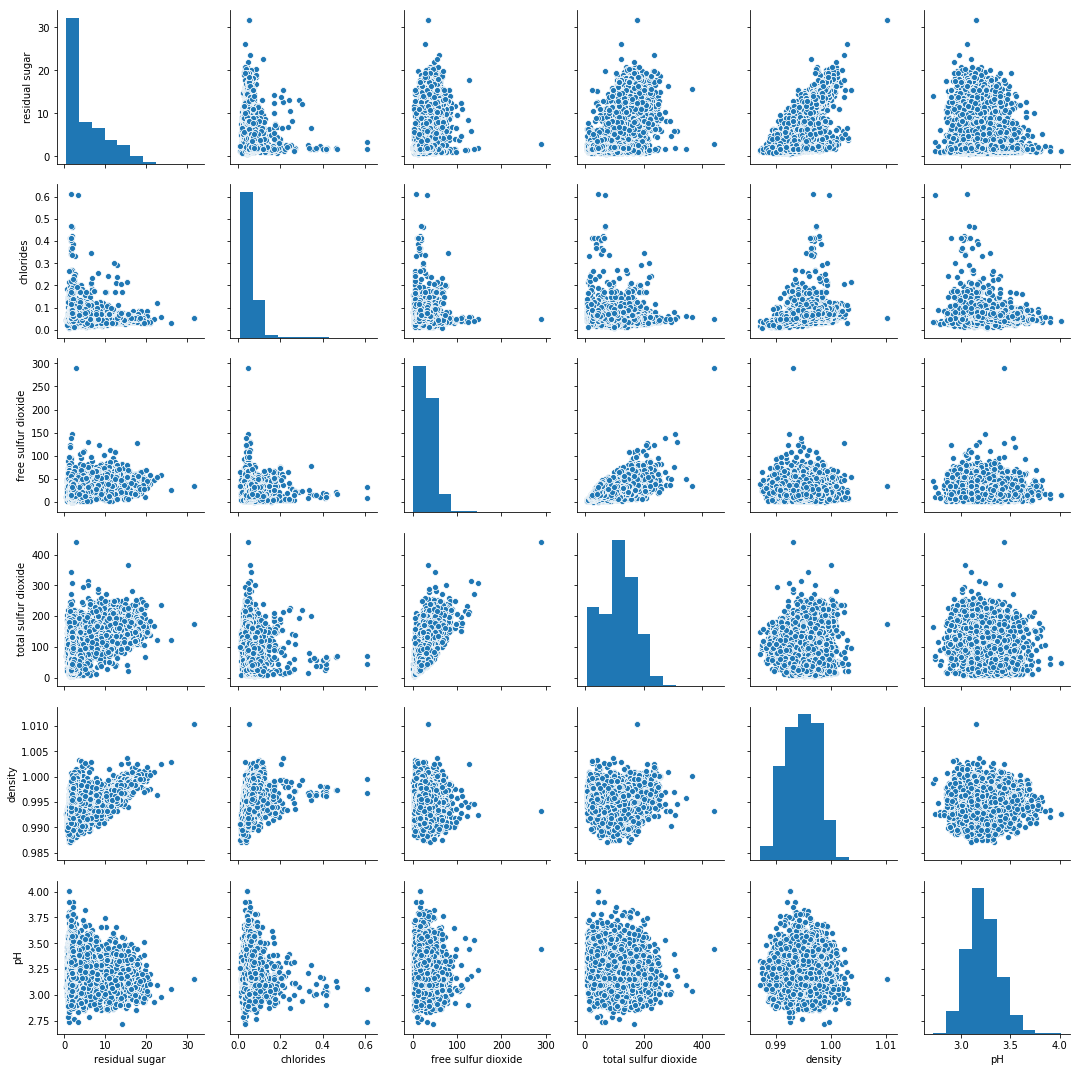

In [95]:
# Pairplot for some of the data feautres
sns.pairplot(data.iloc[:, 4:10])

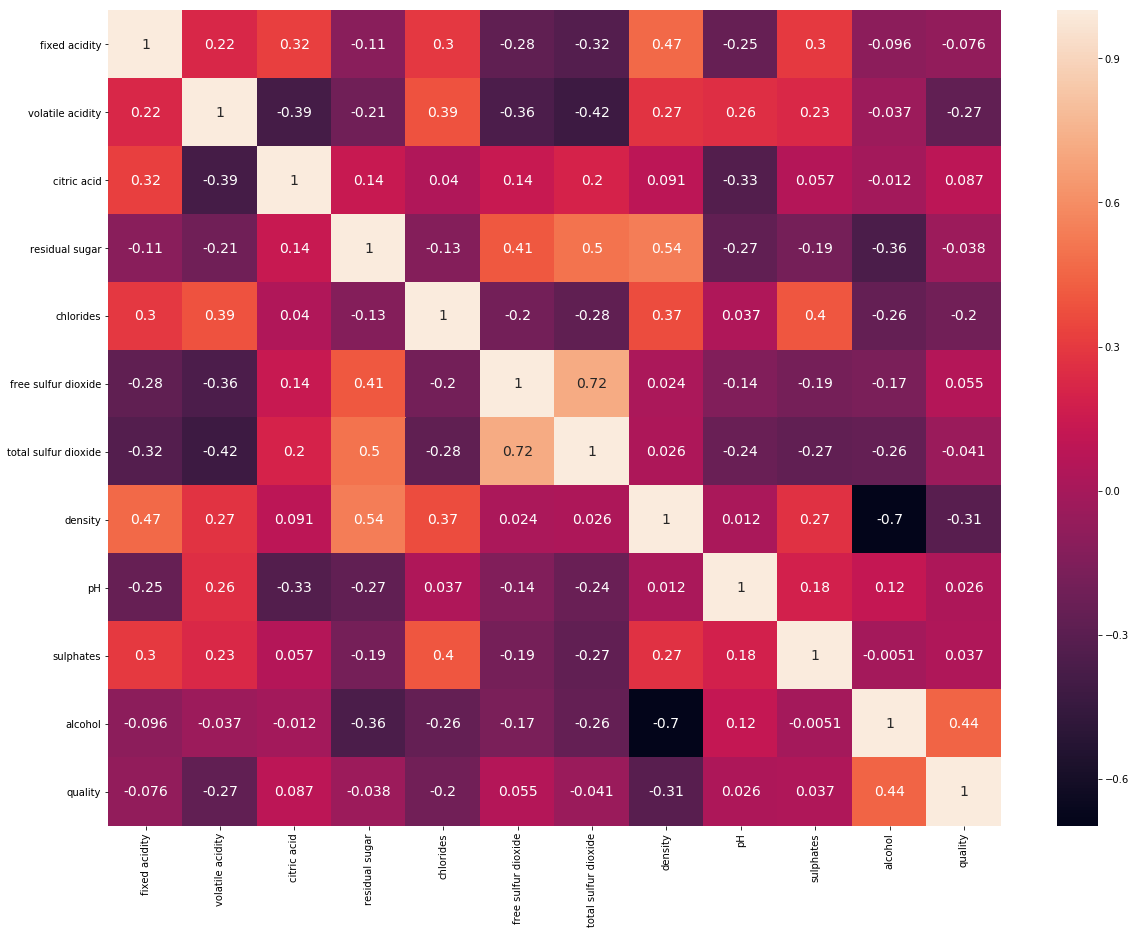

In [96]:
# Plotting correlation table
fig = plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True, annot_kws={"size": 14})

In [97]:
# Divide data into predictors and target X is predictors and Y is target.
X = data.drop("type", axis=1)
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
2,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0


In [98]:
# Y is type column
y = data["type"]
y.value_counts()

white    4390
red      1446
Name: type, dtype: int64

In [99]:
# Mapping white lable by 1 and red by 0
y = y.map({'white': 1, 'red': 0})
y.value_counts()

1    4390
0    1446
Name: type, dtype: int64

In [100]:
# Split dataset into train and validation parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True)

In [101]:
# Check training and test data set shape
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)

X_train : (4377, 12)
X_test  : (1459, 12)
y_train : (4377,)
y_test  : (1459,)


In [102]:
################# CC. Create pipeline #################
#### Pipe using XGBoost

# 5 Pipeline steps
# steps: List of (name, transform) tuples
#       (implementing fit/transform) that are
#       chained, in the order in which they
#       are chained, with the last object an
#       estimator.
#      Format: [(name, transformer), (name, transformer)..(name, estimator)]
steps_xg = [('sts', ss()), ('pca', PCA()), ('xg',  XGBClassifier(silent = False, n_jobs=1))]

# Instantiate Pipeline object
pipe_xg = Pipeline(steps_xg)

# Grid Search Section

In [103]:
##################### Grid Search #################

# 6.  Specify xgboost parameter-range
# 6.1 Dictionary of parameters (16 combinations)
#     Syntax: {
#              'transformerName_parameterName' : [ <listOfValues> ]
#              }
#
parameters = {'xg__learning_rate':  [0.1, 0.3, 0.5, 0.8], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
              'xg__n_estimators':   [50, 65, 85, 100],  # Number of boosted trees to fit
                                                  # l1 and l2 specifications will change
                                                  # the values of coeff of boosted trees
                                                  # but not their numbers
              'xg__max_depth':      [2, 3, 5, 7],
              'pca__n_components' : [0.3, 0.5, 0.7, 0.9]}

In [104]:
#    Grid Search iterations
#    Create Grid Search object first with all necessary
#    specifications. Note that data, X, as yet is not specified
#    Pipeline avoids data leakage during GridSearch
#    See this: https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976
clf = GridSearchCV(pipe_xg,            # pipeline object
                   parameters,         # possible parameters
                   n_jobs = 1,         # USe parallel cpu threads
                   cv =5 ,             # No of folds
                   verbose = 1,         # Higher the value, more the verbosity
                   scoring = ['accuracy', 'roc_auc'],  # Metrics for performance
                   refit = 'roc_auc'   # Refitting final model on what parameters? those which maximise auc
                   )

In [105]:
# Start fitting data to pipeline
clf.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:  4.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sts', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('xg', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_byt...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'xg__learning_rate': [0.1, 0.3, 0.5, 0.8], 'xg__n_estimators': [50, 65, 85, 100], 'xg__max_depth': [2, 3, 5, 7], 'pca__n_components': [0.3, 0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['accuracy', 'roc_auc'], verbose=1)

In [106]:
# Best Score and best parameters
print("Best score :", clf.best_score_ * 100)
print("Best parameter set :", clf.best_params_)

Best score : 99.72156399111867
Best parameter set : {'pca__n_components': 0.9, 'xg__learning_rate': 0.8, 'xg__max_depth': 2, 'xg__n_estimators': 65}


In [107]:
# Making predictions
y_pred = clf.predict(X_test)

In [108]:
# Check Accuracy
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"

'Accuracy: 98.90335846470185'

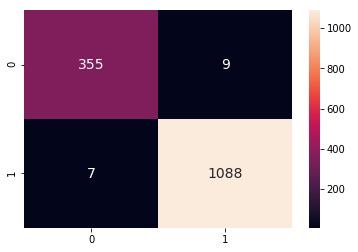

In [109]:
# Confusion matrix
cm = confusion_matrix( y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 14})

In [110]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print("True Positives : ", tp)
print("True Negatives : ", tn)
print("False Positives : ", fp)
print("False Negatives : ", fn)

True Positives :  1088
True Negatives :  355
False Positives :  9
False Negatives :  7


In [111]:
# probbaility of occurrence of each class
y_pred_prob = clf.predict_proba(X_test)
print("y_pred_prob shape : ", y_pred_prob.shape)

y_pred_prob shape :  (1459, 2)


In [112]:
# Probability values in y_pred_prob are ordered
# column-wise, as:
clf.classes_

array([0, 1])

In [113]:
# Draw ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[: , 0], pos_label = 0)

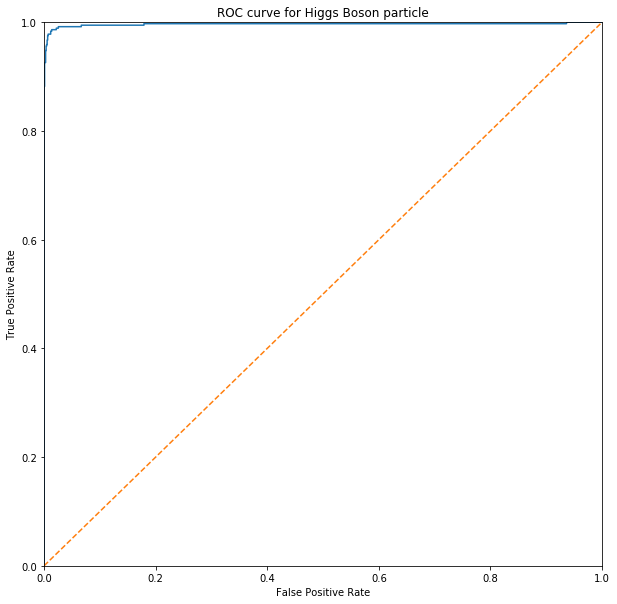

In [114]:
# Plot the ROC curve
fig = plt.figure(figsize=(10,10))          # Create window frame
ax = fig.add_subplot(111)   # Create axes
ax.plot(fpr, tpr)           # Plot on the axes
# Also connect diagonals
ax.plot([0, 1], [0, 1], ls="--")   # Dashed diagonal line
# Labels etc
ax.set_xlabel('False Positive Rate')  # Final plot decorations
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve for Higgs Boson particle')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
plt.show()

In [115]:
# AUC
auc(fpr,tpr)

0.9962579657785138

# Randomized Search Section

In [118]:
##################### EE. Randomized Search #################

# Tune parameters using randomized search
# Hyperparameters to tune and their ranges
parameters = {'xg__learning_rate':  uniform(0, 1),
              'xg__n_estimators':   range(50,100),
              'xg__max_depth':      range(2,7),
              'pca__n_components' : range(5, 10)}

In [119]:
# Tune parameters using random search
# Create the object first
rs = RandomizedSearchCV(pipe_xg,
                        param_distributions=parameters,
                        scoring= ['roc_auc', 'accuracy'],
                        n_iter=15,          # Max combination of parameter to try. Default = 10
                        verbose = 3,
                        refit = 'roc_auc',
                        n_jobs = 4,          # Use parallel cpu threads
                        cv = 7               # No of folds, so n_iter * cv combinations
                        )

In [120]:
# Run random search for 25 iterations.
rs.fit(X_train, y_train)

Fitting 7 folds for each of 15 candidates, totalling 105 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:   24.7s finished


RandomizedSearchCV(cv=7, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('sts', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('xg', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_byt...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1))]),
          fit_params=None, iid='warn', n_iter=15, n_jobs=4,
          param_distributions={'xg__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f07616178d0>, 'xg__n_estimators': range(50, 100), 'xg__max_depth': range(2, 7), 'pca__n_components': range(5, 10)},
          pre_dispatch='2*n_jobs', random_state=None, refit='roc_auc',
          return_train_score='warn', scoring=['roc_auc', 'accuracy'],
          verbose=3)

In [121]:
# Evaluation
print("Best score: ", rs.best_score_)
print("Best parameter set: ", rs.best_params_)

Best score:  0.9969446065436719
Best parameter set:  {'pca__n_components': 9, 'xg__learning_rate': 0.4818226316612859, 'xg__max_depth': 2, 'xg__n_estimators': 89}


In [122]:
# Make predictions
y_pred = rs.predict(X_test)

In [123]:
# Accuracy check
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"

'Accuracy: 98.97189856065799'

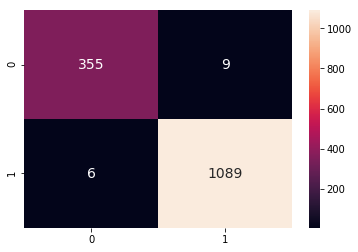

In [124]:
# Confusion matrix
cm = confusion_matrix( y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 14})

In [125]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
print("True Positives : ", tp)
print("True Negatives : ", tn)
print("False Positives : ", fp)
print("False Negatives : ", fn)

True Positives :  1089
True Negatives :  355
False Positives :  9
False Negatives :  6


# Bayes Optimization

In [126]:
"""
Step 1: Define BayesianOptimization function.
    It broadly acts as follows"
    s1. Gets a dictionary of parameters that specifies
        possible range of values for each one of
        the parameters. [Our set: para_set ]
    s2. Picks one value for each one of the parameters
        (from the specified ranges as in (s1)) evaluate,
        a loss-function that is given to it, say,
        accuracy after cross-validation.
        [Our function: xg_eval() ]
    s3. Depending upon the value of accuracy returned
        by the evaluator and also past values of accuracy
        returned, this function, creates gaussian
        processes and picks up another set of parameters
        from the given dictionary of parameters
    s4. The parameter set is then fed back to (s2) above
        for evaluation
    s5. (s2) t0 (s4) are repeated for given number of
        iterations and then final set of parameters
        that optimizes objective is returned

"""

# Which parameters to consider and what is each one's range
para_set = {
           'learning_rate':  (0, 1),                 # any value between 0 and 1
           'n_estimators':   (50,100),               # any number between 50 to 100
           'max_depth':      (2,7),                 # any depth between 3 to 10
           'n_components' :  (5,10)                 # any number between 20 to 30
            }

In [127]:
# Create a function that when passed some parameters
#    evaluates results using cross-validation
#    This function is used by BayesianOptimization() object

def xg_eval(learning_rate,n_estimators, max_depth,n_components):
    
    # 12.1 Make pipeline. Pass parameters directly here
    pipe_xg1 = make_pipeline (ss(),                        # Why repeat this here for each evaluation?
                              PCA(n_components = int(round(n_components))),
                              XGBClassifier(
                                           silent = False,
                                           n_jobs = 4,
                                           learning_rate = learning_rate,
                                           max_depth = int(round(max_depth)),
                                           n_estimators = int(round(n_estimators))
                                           )
                             )

    # 12.2 Now fit the pipeline and evaluate
    cv_result = cross_val_score(estimator = pipe_xg1,
                                X = X_train,
                                y = y_train,
                                cv = 2,
                                n_jobs = 4,
                                scoring = 'f1'
                                ).mean()             # take the average of all results
    # 12.3 Finally return maximum/average value of result
    return cv_result


In [128]:
# This is the main workhorse
#      Instantiate BayesianOptimization() object
#      This object  can be considered as performing an internal-loop
#      i)  Given parameters, xg_eval() evaluates performance
#      ii) Based on the performance, set of parameters are selected
#          from para_set and fed back to xg_eval()
#      (i) and (ii) are repeated for given number of iterations
#
xgBO = BayesianOptimization(
                             xg_eval,     # Function to evaluate performance.
                             para_set     # Parameter set from where parameters will be selected
                             )

In [129]:
# Gaussian process parameters
#     Modulate intelligence of Bayesian Optimization process
#     This parameters controls how much noise the GP can handle,
#     so increase it whenever you think that extra flexibility is needed.
#     gp_params = {"alpha": 1e-5}      # Initialization parameter for gaussian process.
#
# Fit/train (so-to-say) the BayesianOptimization() object
#     Start optimization. 25minutes
#     Our objective is to maximize performance (results)
xgBO.maximize(init_points=5,    # Number of randomly chosen points to
                                 # sample the target function before
                                 #  fitting the gaussian Process (gp)
                                 #  or gaussian graph
               n_iter=9,        # Total number of times the
               #acq="ucb",       # ucb: upper confidence bound
                                 #   process is to be repeated
                                 # ei: Expected improvement
               # kappa = 1.0     # kappa=1 : prefer exploitation; kappa=10, prefer exploration
#              **gp_params
               )

|   iter    |  target   | learni... | max_depth | n_comp... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.9926   |  0.3266   |  5.622    |  9.535    |  72.77    |
|  2        |  0.9918   |  0.1266   |  2.166    |  8.027    |  96.95    |
|  3        |  0.9921   |  0.9329   |  3.993    |  8.98     |  61.46    |
|  4        |  0.9921   |  0.9236   |  3.334    |  6.464    |  86.47    |
|  5        |  0.9929   |  0.7161   |  6.494    |  9.568    |  90.63    |
|  6        |  0.992    |  0.71     |  6.977    |  5.016    |  50.02    |
|  7        |  0.991    |  0.1276   |  2.091    |  9.907    |  50.03    |
|  8        |  0.9913   |  0.1273   |  6.435    |  5.363    |  99.99    |
|  9        |  0.9924   |  0.7527   |  6.7      |  9.958    |  99.97    |
|  10       |  0.9915   |  0.5458   |  6.885    |  5.227    |  99.99    |
|  11       |  0.9895   |  0.006467 |  6.864    |  9.859    |  50.11    |
|  12       |  0.9938   |  0.6522   | 

In [130]:
# Get values of parameters that maximise the objective
max_xgBO = xgBO.max

print("\033[1mBest Score:\033[0m ", max_xgBO["target"])



maxlen = max([len(i) for i in max_xgBO["params"].keys()])

print("\n\n\033[1mMaximum performing combination:\033[0m \n")
for key, value in max_xgBO["params"].items():
    print(key, " " * (maxlen - len(key) + 5), value)



Best Score:  0.9937720508856309


Maximum performing combination: 

learning_rate       0.6522314020152139
max_depth           2.3198046203964795
n_components        9.973329286527946
n_estimators        99.98164456653102


 # Ending this Kernel here